This code is part of Lydia Armini's work as a resarch assistant at Göteborgs Universitet and Chalmers University of Technology
Please contact Beatriz Cabrero-Daniel beatriz.cabrero-daniel@gu.se for questions.

In [74]:
# imports
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import zCurve as z
import math

Function to downsample any array to a target length (to merge all sensor signals):

In [75]:
def downsample(arr, target_len):
    n = arr.shape[0]
    indices = [round(i * (n - 1) / (target_len - 1)) for i in range(target_len)]

    if arr.ndim == 2:
        arr =  arr[indices, :]
    else: 
        arr = arr[indices]
    return arr

In [ ]:
def InterpolateData(filePath, date, parentFolder, fileLowestFreq):
    dirPath = parentFolder + date + '/processed_log'
    values_old = np.loadtxt(dirPath + filePath + "/value.csv", delimiter=',')
    times_old = np.loadtxt(dirPath + filePath + "/t.csv", delimiter=',')
    times_lowest = np.loadtxt(dirPath + fileLowestFreq + "/t.csv", delimiter=',')
    target_len = len(times_lowest)
    times_new = np.array(downsample(times_old, target_len=target_len))
    values_new = np.array(downsample(values_old, target_len=target_len))
    #time_lc_mask = []
    time_lc_mask = np.zeros_like(times_new)
    for i in range(4):
        lcFilePath = dirPath + filePath + f'/t_lc_{i+1}'
        if not os.path.exists(lcFilePath):
            break
        times_lc = np.loadtxt(dirPath + f'/IMU/gyro/t_lc_{i+1}', delimiter=',')
        #tmp_mask = np.zeros(target_len)
        lc_start, lc_end = np.argmin(np.abs(times_lowest-times_lc[0])), np.argmin(np.abs(times_lowest-times_lc[-1]))
        #tmp_mask[lc_start:lc_end+1] = np.ones_like(tmp_mask[lc_start:lc_end+1])
        time_lc_mask[lc_start:lc_end+1] = 1
        #time_lc_mask.append(tmp_mask)
    #time_lc_mask = np.array(time_lc_mask).T
    return times_new, values_new, time_lc_mask

def DataToCSV(date, parentFolder):
    filePaths = ["/CAN/speed", "/CAN/steering_angle", "/IMU/accelerometer", "/IMU/gyro"]
    columns = ['Time (seconds)', 'Time (microseconds)', 'Speed (m/s)', 'Steering angle (deg)', 'Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)',
                                                        'Angular velocity x (deg/s)', 'Angular velocity y (deg/s)', 'Angular velocity z (deg/s)', 'Lane change']
    times_files = [(parentFolder + date + '/processed_log'+ fileName + "/t.csv") for fileName in filePaths]
    tmp_ind = np.argmin([len(np.loadtxt(fileName, delimiter=',')) for fileName in times_files])
    file_lowest_freq = filePaths[tmp_ind]
    start_ind = 2
    for filePath in filePaths:
        t, val, t_lc_mask = InterpolateData(date=date, filePath=filePath, parentFolder=parentFolder, fileLowestFreq = file_lowest_freq)
        if start_ind == 2:
            #numberOfLc = t_lc_mask.shape[1]
            #for i in range(numberOfLc):
                #columns.append(f'Lane change {i+1}')
            val_matrix = np.zeros((len(t), len(columns)))
        if val.ndim == 2:
            end_ind = start_ind + val.shape[1]
            val_matrix[:, start_ind:end_ind] = val
            start_ind = end_ind
        else:
            val_matrix[:, start_ind] = val
            start_ind = start_ind + 1
    # Lane changes
    #val_matrix[:, end_ind:end_ind + numberOfLc] = t_lc_mask
    val_matrix[:, -1] = t_lc_mask
    # Time
    t_microseconds = (t * 10**6).astype(int)
    val_matrix[:, 0] = t_microseconds // (10**6) #np.zeros_like(t)
    val_matrix[:, 1] = t_microseconds % (10**6) 
    df = pd.DataFrame(val_matrix, columns=columns)
    df.to_csv(parentFolder + date + "/" + date + "_merged_data_sensor.csv", sep=";", index=False)

In [ ]:
def PlotValues(df, listOfColumnNames):
    times = df['Time (microseconds)']
    times_lc = times[df['Lane change'] == 1]
    
    numberOfLc = 0
    for i in range(1, 4):
        if f'Lane change {i}' in df.index:
            numberOfLc = numberOfLc +1

    fig, ax = plt.subplots(nrows = len(listOfColumnNames))

    for i, keyName in enumerate(listOfColumnNames): 
        values = df[keyName]
        values_lc = values[df['Lane change'] == 1]
        ax[i].plot(times, values)
        for lcInd in range(1, numberOfLc + 1):
            lcKeyName = f'Lane change {i}'
            times_lc = times[df[lcKeyName] == 1] 
            values_lc = values[df[lcKeyName] == 1] 
            ax[i].plot(times_lc, values_lc)

        ax.set_ylabel(keyName)
        ax.set_xlabel('Time (miliseconds)')
        ax[i] = ax.plot()
    return

# Reading and reformating data

In [12]:
parentFolder = 'input_data/Lanechangecitos/'

for date in os.listdir(parentFolder):    
    if '.DS_Store' in date:
        continue
    DataToCSV(date=date, parentFolder=parentFolder)
    data = pd.read_csv(parentFolder + date + "/" + date + "_merged_data_sensor.csv")
    print("Read files in " + parentFolder + date + " and stored them in " + date + "_merged_data_sensor.csv")

Read files in input_data/Lanechangecitos/2018-07-29--12-02-42_29 and stored them in 2018-07-29--12-02-42_29_merged_data_sensor.csv
Read files in input_data/Lanechangecitos/2018-08-17--14-55-39_7 and stored them in 2018-08-17--14-55-39_7_merged_data_sensor.csv
Read files in input_data/Lanechangecitos/2018-08-03--10-35-16_14 and stored them in 2018-08-03--10-35-16_14_merged_data_sensor.csv
Read files in input_data/Lanechangecitos/2018-08-17--12-07-08_37 and stored them in 2018-08-17--12-07-08_37_merged_data_sensor.csv
Read files in input_data/Lanechangecitos/2018-07-30--13-44-30_8 and stored them in 2018-07-30--13-44-30_8_merged_data_sensor.csv
Read files in input_data/Lanechangecitos/2018-07-31--20-50-28_6 and stored them in 2018-07-31--20-50-28_6_merged_data_sensor.csv
Read files in input_data/Lanechangecitos/2018-07-27--06-03-57_3 and stored them in 2018-07-27--06-03-57_3_merged_data_sensor.csv


## Plotting data for visual inspection

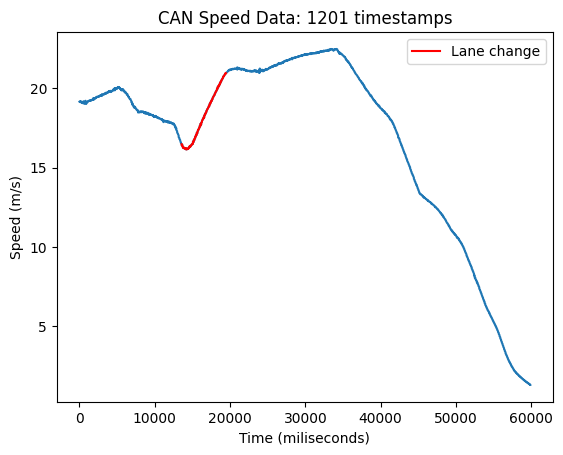

In [ ]:
times = data['Time (microseconds)']
values = data['Speed (m/s)']
times_lc = times[data['Lane change 1'] == 1]
values_lc = values[data['Lane change 1'] == 1]

fig, ax = plt.subplots(nrows=1)
ax.plot(times, values)
ax.plot(times[data['Lane change 1'] == 1], values[data['Lane change 1'] == 1], color='red', label ='Lane change')
ax.set_title(f'CAN Speed Data: {times.shape[0]} timestamps')
ax.set_ylabel('Speed (m/s)')
ax.set_xlabel('Time (microseconds)')
ax.legend()
#plt.savefig('./figs/plots_2018-07-27--06-03-57_3/speed.png')
plt.show()

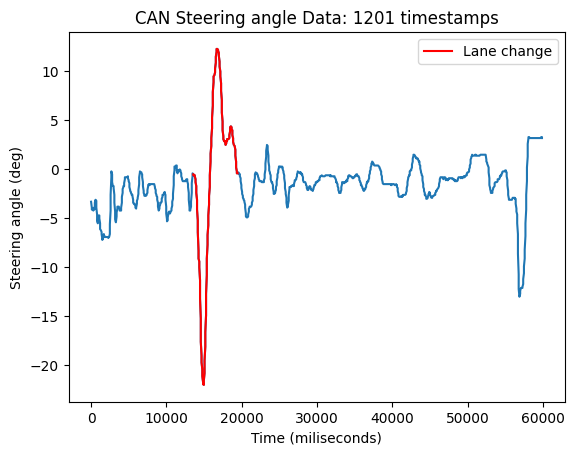

In [80]:
values = data['Steering angle (deg)']
values_lc = values[data['Lane change 1'] == 1]

fig, ax = plt.subplots()
ax.plot(times, values)
ax.plot(times_lc, values_lc, color='red', label ='Lane change')
ax.set_title(f'CAN Steering angle Data: {times.shape[0]} timestamps')
ax.set_ylabel('Steering angle (deg)')
ax.set_xlabel('Time (miliseconds)')

#ax.set_xlim(19000, 20000)
ax.legend()
#plt.savefig('./figs/plots_2018-07-27--06-03-57_3/speed.png')
plt.show()

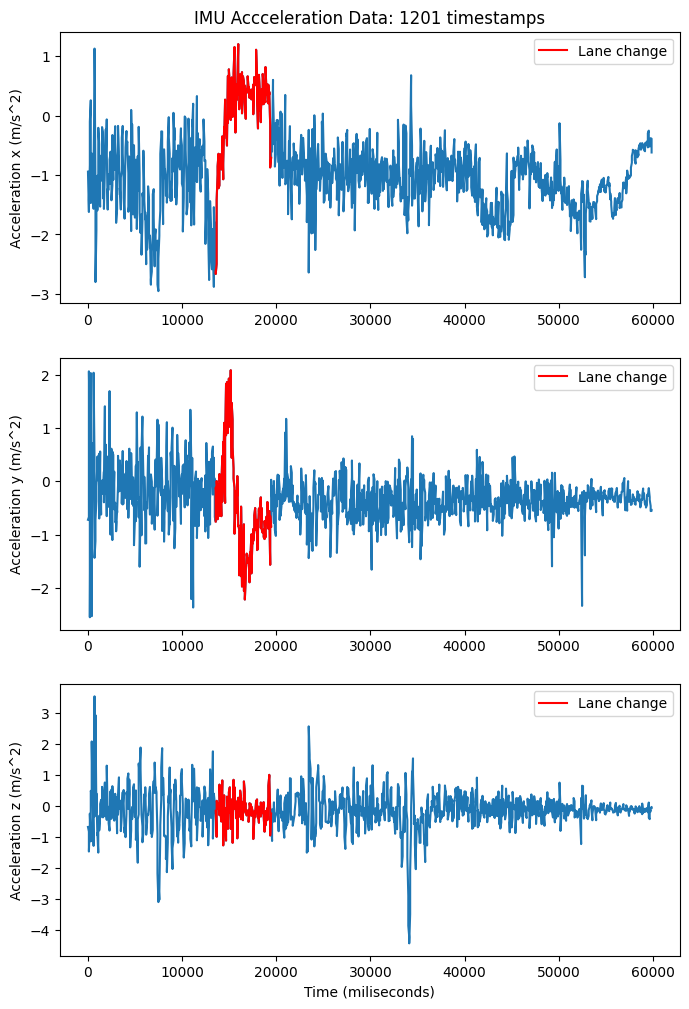

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize = (8,12))

values = data['Acceleration x (m/s^2)']
values_lc = values[data['Lane change 1'] == 1]

ax[0].plot(times, values)
ax[0].plot(times_lc, values_lc, color='red', label ='Lane change')

values = data['Acceleration y (m/s^2)']
values_lc = values[data['Lane change 1'] == 1]

ax[1].plot(times, values )
ax[1].plot(times_lc, values_lc, color ='red', label ='Lane change')

values = data['Acceleration z (m/s^2)']
values_lc = values[data['Lane change 1'] == 1]

ax[2].plot(times , values + 9.8)
ax[2].plot(times_lc, values_lc + 9.8, color='red', label ='Lane change')

ax[0].set_title(f'IMU Accceleration Data: {times.shape[0]} timestamps')

ax[0].set_ylabel('Acceleration x (m/s^2)')
ax[1].set_ylabel('Acceleration y (m/s^2)')
ax[2].set_ylabel('Acceleration z (m/s^2)')

ax[2].set_xlabel('Time (microseconds)')
#for i in range(3):
    #ax[i].set_xlim(19000, 20000)

ax[0].legend()
ax[1].legend()
ax[2].legend()
#plt.savefig('./figs/2018-07-27--06-03-57_3/acceleration.png')
plt.show()

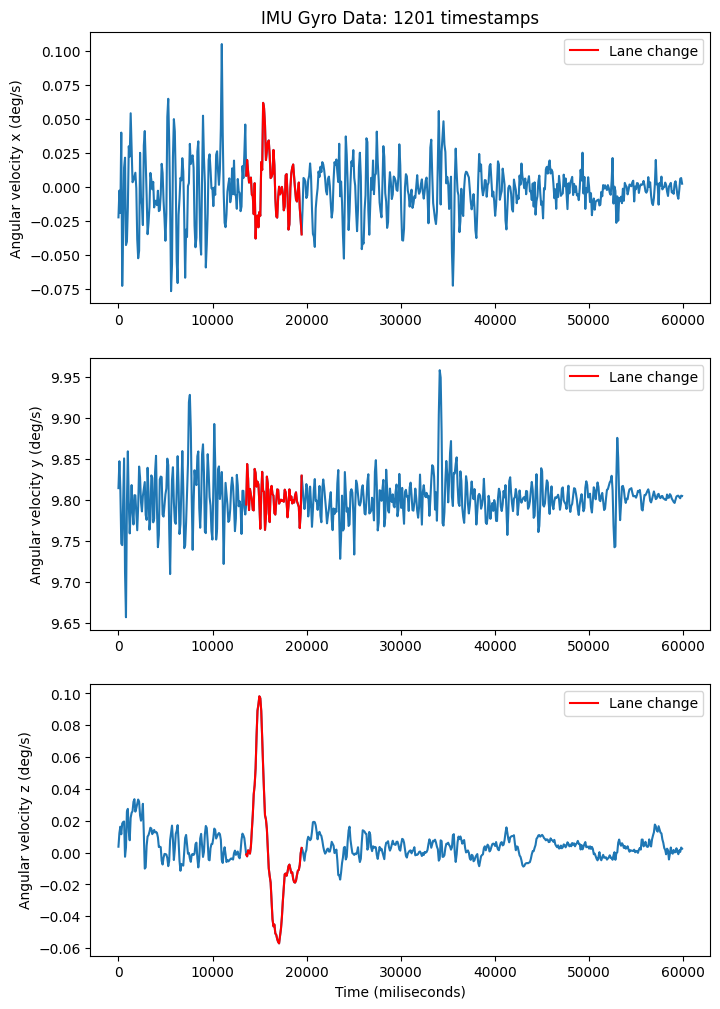

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize = (8,12))

values = data['Angular velocity x (deg/s)']
values_lc = values[data['Lane change 1'] == 1]

ax[0].plot(times, values)
ax[0].plot(times_lc, values_lc, color='red', label ='Lane change')

values = data['Angular velocity y (deg/s)']
values_lc = values[data['Lane change 1'] == 1]

ax[1].plot(times, values + 9.8)
ax[1].plot(times_lc, values_lc + 9.8, color ='red', label ='Lane change')

values = data['Angular velocity z (deg/s)']
values_lc = values[data['Lane change 1'] == 1]

ax[2].plot(times, values)
ax[2].plot(times_lc, values_lc, color='red', label ='Lane change')


ax[0].set_title(f'IMU Gyro Data: {times.shape[0]} timestamps')

ax[0].set_ylabel('Angular velocity x (deg/s)')
ax[1].set_ylabel('Angular velocity y (deg/s)')
ax[2].set_ylabel('Angular velocity z (deg/s)')

ax[2].set_xlabel('Time (microseconds)')

ax[0].legend()
ax[1].legend()
ax[2].legend()
#plt.savefig('./figs/2018-07-27--06-03-57_3/acceleration.png')
plt.show()
